# Visualizing all the battles in GoT


In [1]:
import re
from typing import Tuple, Optional
from pathlib import Path
from xml import dom

from IPython.display import SVG, display

class Map:
    COLOR_REGEX = re.compile("fill:#([0-9a-fA-F]{2})([0-9a-fA-F]{2})([0-9a-fA-F]{2})")

    def __init__(self, path: Path):
        self.data = dom.minidom.parse(str(path))

    def __getitem__(self, name: str) -> Optional[Tuple[int, int, int]]:
        path = self._find_country(name)
        if path is None:
            return None

        color_code = Map.COLOR_REGEX.match(path.getAttribute('style'))
        if color_code is None:
            return None

        return tuple(int(code, 16) for code in color_code.group(1, 2, 3))

    def __setitem__(self, key: str, value: Tuple[int, int, int]):
        path = self._find_country(key)
        if path is None:
            raise ValueError(f"Unknown country '{key}'.")

        style = "fill:#{:02x}{:02x}{:02x}".format(value[0], value[1], value[2])
        if 'style' in path.attributes:
            style = Map.COLOR_REGEX.sub(style, path.getAttribute('style'))
        path.setAttribute('style', style)

    def _find_country(self, name: str) -> Optional[dom.Node]:
        name = "".join(name.split()).lower()
        if name.startswith("the"):
            name = name[3:]
        
        countries = self.data.getElementsByTagName('path')
        for county in countries:
            if county.getAttribute("id") == name:
                return county
        return None

    def show(self):
        display(SVG(data=str(self)))

    def __str__(self):
        return self.data.toxml()


In [2]:
import pandas as pd
import numpy as np
from matplotlib import colors, cm, pyplot as plt

def plot_colormap(x_range: Tuple[int, int], colormap):
    a = np.array([x_range])
    plt.figure(figsize=(5, 1.5))
    plt.imshow(a, cmap=colormap)
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    plt.colorbar(orientation="horizontal", cax=cax)

def plot_map(data: pd.DataFrame):
    map = Map(Path.cwd() / "res" / "map.svg")

    normalizer = colors.Normalize(vmin=0, vmax=data.max())
    mapper = cm.ScalarMappable(norm=normalizer, cmap=plt.get_cmap('Reds') )
    
    for region, value in data.iteritems():
        map[region] = [int(x * 255) for x in mapper.to_rgba(value)[:3]]
        
    map.show()
    plot_colormap((1, data.max()), mapper.get_cmap())
    plt.show()

# Load the data
data = pd.read_csv(Path.cwd() / "data" / "battles.csv")


## Number of battles per region

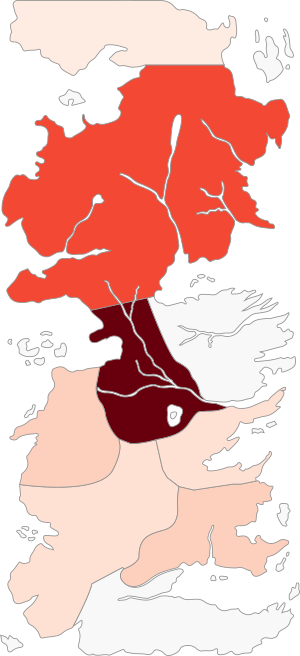

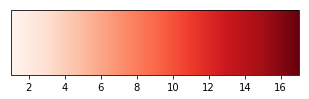

In [3]:
plot_map(
    data['region'].value_counts()
)


## Number of participating soldiers per region

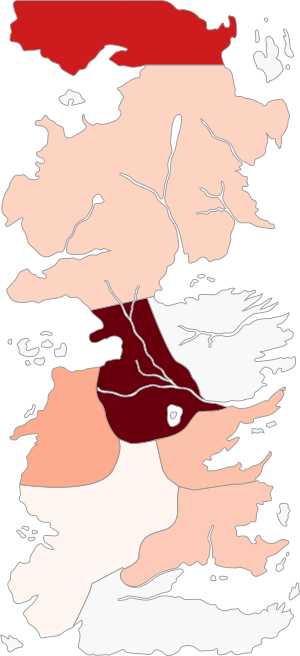

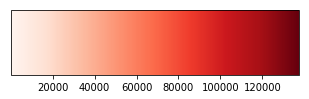

In [4]:
plot_map(
    data.groupby('region')[['attacker_size', 'defender_size']].sum(skipna=True).sum(axis=1)
)


## Number of dead major characters per region

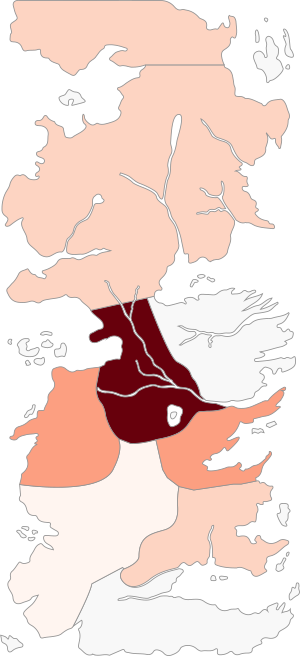

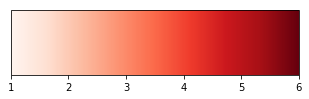

In [5]:
plot_map(
    data.groupby('region')['major_death'].sum()
)


Visualizing of the prediction data set

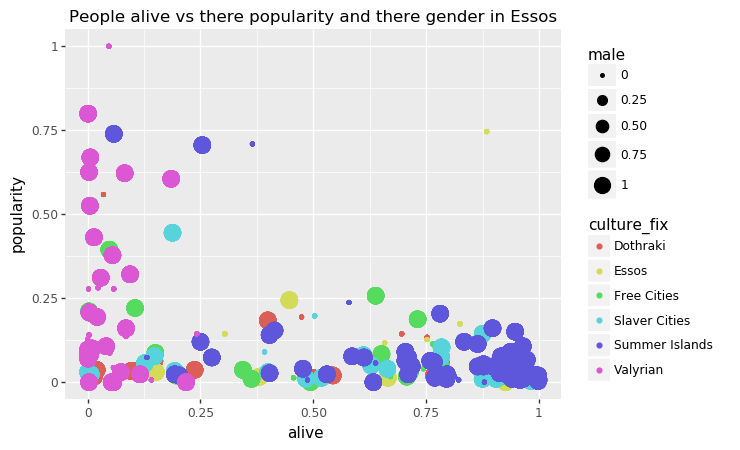

In [31]:
from plotnine import *

def fix_data(data_pre):
    data = data_pre.melt(id_vars=['alive','male','culture','popularity','actual']).dropna(how = "any")
    i = []
    for name in data["culture"]:
        if (name == "Free folk") | (name == "free folk") | (name == "Wildling") or (name == 'Wildlings') :
            i.append("Free Folk")
        elif (name == "Westermen") | (name == "westermen") | (name == "westerman") | (name == "Westerman") | (name == "Westermen"):
            i.append("Westerlands")
        elif (name == "northmen") | (name == "Northern mountain clans") | (name == "Crannogmen"):
            i.append("Northmen")
        elif (name == "Dornishmen") | (name == "Dornish"):
            i.append("Dorne")
        elif (name == "Summer Islander") | (name == "Summer Isles") | (name == "Ironborn"):
            i.append("Summer Islands")
        elif (name == "Rivermen") |(name == "Ironmen") | (name == "ironborn"):
            i.append("Riverlands")
        elif (name == "Reach") |(name == "Reachmen"):
            i.append("The Reach")
        elif ((name == "Lyseni") | (name == "Lysene") |(name == "Braavosi") | (name == "Braavos") | 
        (name == "Qohor") | (name == "Tyroshi") | (name == "Norvos") | (name == "Norvoshi") | (name == "Pentoshi")
             | (name == "Myrish")):
            i.append("Free Cities")
        elif (name == "Valemen") | (name == "Vale mountain clans") :
            i.append("Vale")
        elif ((name == "Meereenese") | (name == "Meereen") | (name == "Astapori") | (name == "Astapor")
             | (name == "Ghiscari") | (name == "Ghiscaricari")):
            i.append("Slaver Cities")
        elif name == "Stormlander":
            i.append("Stormlands")
        elif ((name == "Qarth")| (name == "Asshai")| (name == "Asshai'i") |(name == "Naathi") | (name == "Ibbenese") 
              | (name == "Lhazarene") | (name == "Lhazareen") | (name == "Qartheen")):
            i.append("Essos")
        elif ((name == "Sistermen") | (name == "First Men") | (name == "Andal") | (name == "Andals")
        | (name == "Rhoynar")):
            i.append("Westeros")

        else:
            i.append(name)
    
    data["culture_fix"] = i 
    co = {'Riverlands':"Westeros", 'Dorne': "Westeros", 'Free Folk':"Westeros" ,'Northmen':"Westeros",
              'Vale':"Westeros", 'The Reach':"Westeros" ,'Westerlands':"Westeros" , 'Westeros':"Westeros", 
              'Stormlands':"Westeros", 'Valyrian' : 'Essos','Free Cities': 'Essos', 'Dothraki': 'Essos', 
              'Slaver Cities': 'Essos', 'Essos': 'Essos', 'Summer Islands': 'Essos' }
    data["Continents"] = data["culture_fix"] .apply(lambda x: co[x])

    return data

# Load the data
data_pre = pd.read_csv(Path.cwd() / "data" / "character-predictions.csv")



data_fix = fix_data(data_pre)
data_west = data_fix[data_fix["Continents"] == "Westeros"]
data_essos = data_fix[data_fix["Continents"] == "Essos"]
        
fig_1 = (ggplot(data_essos, aes( y = 'popularity' ,x= 'alive', color="culture_fix",  size = "male"))
 + geom_point()).draw()
fig_1.axes[0].set(title = "People alive vs there popularity and there gender in Essos");

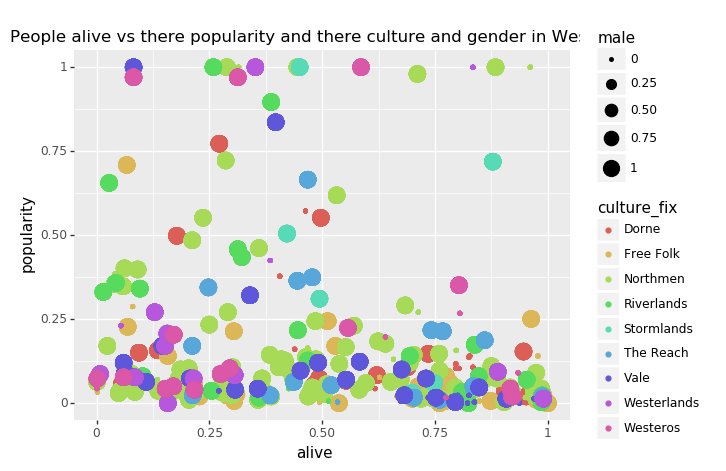

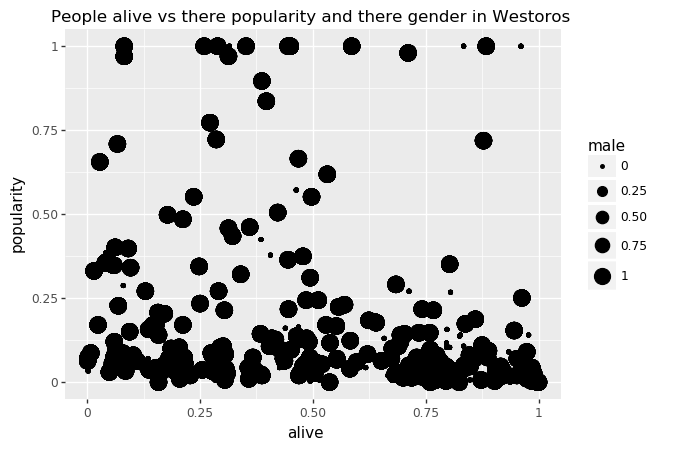

In [34]:
fig_2 = (ggplot(data_west, aes( y = 'popularity' ,x= 'alive',  color="culture_fix" , size = "male"))
+ geom_point()).draw()
fig_2.axes[0].set(title = "People alive vs there popularity and there culture and gender in Westoros ");
fig_3 = (ggplot(data_west, aes( y = 'popularity' ,x= 'alive', size = "male"))
+ geom_point()).draw()
fig_3.axes[0].set(title = "People alive vs there popularity and there gender in Westoros ");


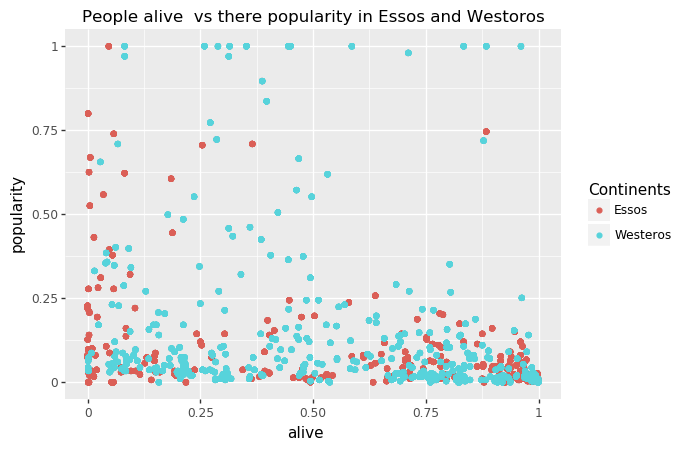

In [32]:
fig_4 = (ggplot(data_fix, aes( y = 'popularity' ,x = 'alive',  color="Continents"))
+ geom_point()).draw()
fig_4.axes[0].set(title = "People alive  vs there popularity in Essos and Westoros");

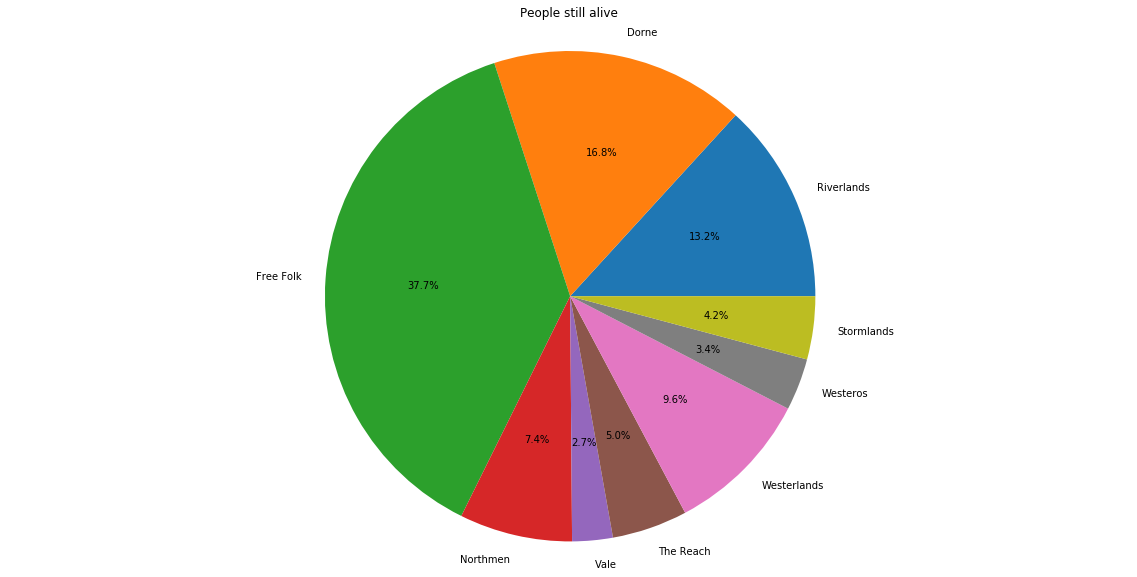

In [12]:
# Pie chart of how many people are still alive of each culture
# only use limited set of cultures
data_alive = data_west.groupby("culture_fix").sum()
labels = data_west["culture_fix"].unique()

# Plot
fig, ax = plt.subplots(figsize=(20,10))

ax.pie(data_alive["alive"], labels=labels, autopct='%1.1f%%')
ax.set_title("People still alive")

ax.axis('equal')
plt.show()